### Kaggle Link
https://www.kaggle.com/c/kkbox-churn-prediction-challenge

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

from datetime import datetime

sns.set(style='whitegrid')

pd.set_option('display.max_columns', None)  

%matplotlib inline

In [2]:
parser = lambda x : pd.to_datetime(x, errors='coerce')

df_train = pd.read_csv('../Data/Kaggle/Churn/train.csv')
df_members = pd.read_csv('../Data/Kaggle/Churn/members.csv',
                         parse_dates=['registration_init_time', 'expiration_date'], date_parser=parser)
df_transactions = pd.read_csv('../Data/Kaggle/Churn/transactions.csv', 
                              parse_dates=['transaction_date', 'membership_expire_date'], date_parser=parser)
df_user_logs = pd.read_csv('../Data/Kaggle/Churn/user_logs.csv')

df_test = pd.read_csv('../Data/Kaggle/Churn/sample_submission_zero.csv')

### Tables

##### train.csv: the train set, containing the user ids and whether they have churned.
    - msno: user id
    - is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn, is_churn = 0 means renewal.
    
##### user_logs.csv: daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.
    - msno: user id
    - date: format %Y%m%d
    - num_25: # of songs played less than 25% of the song length
    - num_50: # of songs played between 25% to 50% of the song length
    - num_75: # of songs played between 50% to 75% of of the song length
    - num_985: # of songs played between 75% to 98.5% of the song length
    - num_100: # of songs played over 98.5% of the song length
    - num_unq: # of unique songs played
    - total_secs: total seconds played

##### transactions.csv: transactions of users up until 2/28/2017.
    - msno: user id
    - payment_method_id: payment method
    - payment_plan_days: length of membership plan in days
    - plan_list_price: in New Taiwan Dollar (NTD)
    - actual_amount_paid: in New Taiwan Dollar (NTD)
    - is_auto_renew
    - transaction_date: format %Y%m%d
    - membership_expire_date: format %Y%m%d
    - is_cancel: whether or not the user canceled the membership in this transaction.  
    
##### members.csv: user information. Note that not every user in the dataset is available.
    - msno
    - city
    - bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
    - gender
    - registered_via: registration method
    - registration_init_time: format %Y%m%d
    - expiration_date: format %Y%m%d

In [3]:
df_transactions = df_transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
df_transactions = df_transactions.drop_duplicates(subset=['msno'], keep='first')
df_transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,v9qq9up34ELNaGex7Yl0CvqwnRbh3qYgIu791AZN16s=,41,30,99,99,1,2017-02-28,2017-03-31,0
1,gxDtfzWgv9f2efeTFZfasyzjoO+xLwvrM501RcU8uZU=,40,30,149,149,1,2017-02-28,2017-03-27,0
2,wnanA7wQWo2kRKHJ+EAcAhllu7owvS3RbD7GvGUOWvY=,41,30,99,99,1,2017-02-28,2017-03-31,0
3,3+ECUXPd2GZYiniQMrRHzYLqQZ5LwsKYkrktEbGd4Wo=,41,30,99,99,1,2017-02-28,2017-03-31,0
4,OJwA/1avEFnk5nIWjSWmFYJU25o+Q+RMvaWiAXGKVQU=,41,30,99,99,1,2017-02-28,2017-03-31,0


### Merging

#### Train

In [4]:
df_train = df_train.merge(df_members, how='left', on=['msno'])
df_train.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,2005-04-06,2017-09-07
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,2005-04-07,2017-03-21
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,2005-10-16,2017-02-03
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,2005-11-02,2017-09-26
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,2005-12-28,2017-09-27


In [5]:
df_train = df_train.merge(df_transactions, how='left', on=['msno'])
df_train.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,2005-04-06,2017-09-07,38,30,149,149,0,2017-01-07,2017-02-06,0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,2005-04-07,2017-03-21,39,30,149,149,1,2017-02-24,2017-03-21,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,2005-10-16,2017-02-03,39,30,149,149,1,2017-01-12,2017-02-03,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,2005-11-02,2017-09-26,38,410,1788,1788,0,2016-01-06,2017-02-20,0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,2005-12-28,2017-09-27,38,30,149,149,0,2017-01-28,2017-02-27,0


In [6]:
df_train = df_train.merge(df_user_logs, how='left', on=['msno'])
df_train.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,average_num_25,average_num_50,average_num_75,average_num_985,average_num_unq,average_total_secs
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,2005-04-06,2017-09-07,38,30,149,149,0,2017-01-07,2017-02-06,0,1.961538,0.615385,0.730769,0.423077,15.730769,17.769231
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,2005-04-07,2017-03-21,39,30,149,149,1,2017-02-24,2017-03-21,1,0.857965,0.301344,0.232246,0.341651,19.082534,13.880998
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,2005-10-16,2017-02-03,39,30,149,149,1,2017-01-12,2017-02-03,1,6.624473,4.008439,1.274262,2.021097,42.333333,48.662447
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,2005-11-02,2017-09-26,38,410,1788,1788,0,2016-01-06,2017-02-20,0,9.884354,3.292517,2.434014,2.223129,24.585034,25.141497
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,2005-12-28,2017-09-27,38,30,149,149,0,2017-01-28,2017-02-27,0,1.832454,0.941953,0.899736,4.258575,90.674142,95.875989


In [7]:
df_train.memory_usage(index=True).sum()

182699304

#### Test

In [8]:
df_test = df_test.merge(df_members, how='left', on=['msno'])
df_test.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,0,5.0,28.0,male,3.0,2013-12-23,2017-08-22
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,0,13.0,20.0,male,3.0,2013-12-23,2017-05-19
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,0,13.0,18.0,male,3.0,2013-12-27,2017-09-19
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,0,1.0,0.0,NaN,7.0,2014-01-09,2016-03-25
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,0,13.0,35.0,female,7.0,2014-01-25,2018-02-18


In [9]:
df_test = df_test.merge(df_transactions, how='left', on=['msno'])
df_test.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,0,5.0,28.0,male,3.0,2013-12-23,2017-08-22,38.0,30.0,149.0,149.0,0.0,2017-02-28,2017-03-30,0.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,0,13.0,20.0,male,3.0,2013-12-23,2017-05-19,36.0,30.0,180.0,180.0,0.0,2017-02-10,2017-03-12,0.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,0,13.0,18.0,male,3.0,2013-12-27,2017-09-19,38.0,30.0,149.0,149.0,0.0,2017-01-30,2017-03-07,0.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,0,1.0,0.0,NaN,7.0,2014-01-09,2016-03-25,35.0,7.0,0.0,0.0,0.0,2016-02-25,2016-03-25,0.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,0,13.0,35.0,female,7.0,2014-01-25,2018-02-18,41.0,30.0,99.0,99.0,1.0,2016-09-01,2017-03-05,0.0


In [10]:
df_test = df_test.merge(df_user_logs, how='left', on=['msno'])
df_test.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,average_num_25,average_num_50,average_num_75,average_num_985,average_num_unq,average_total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,0,5.0,28.0,male,3.0,2013-12-23,2017-08-22,38.0,30.0,149.0,149.0,0.0,2017-02-28,2017-03-30,0.0,6.924528,1.584906,0.830189,1.547170,32.320755,8.113208
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,0,13.0,20.0,male,3.0,2013-12-23,2017-05-19,36.0,30.0,180.0,180.0,0.0,2017-02-10,2017-03-12,0.0,1.986486,0.554054,0.283784,0.337838,10.567568,9.500000
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,0,13.0,18.0,male,3.0,2013-12-27,2017-09-19,38.0,30.0,149.0,149.0,0.0,2017-01-30,2017-03-07,0.0,32.748447,2.248447,1.214286,1.239130,20.127329,46.167702
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,0,1.0,0.0,NaN,7.0,2014-01-09,2016-03-25,35.0,7.0,0.0,0.0,0.0,2016-02-25,2016-03-25,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,0,13.0,35.0,female,7.0,2014-01-25,2018-02-18,41.0,30.0,99.0,99.0,1.0,2016-09-01,2017-03-05,0.0,1.203125,0.730469,0.449219,0.277344,12.074219,13.121094


In [11]:
df_test.memory_usage(index=True).sum()

178656640

In [12]:
del df_members
del df_transactions
del df_user_logs

In [13]:
df_ids = df_test['msno']
for df in [df_train, df_test]:
    df.drop(['msno'], axis=1, inplace=True)

In [14]:
gc.collect()

299

### Missing Data

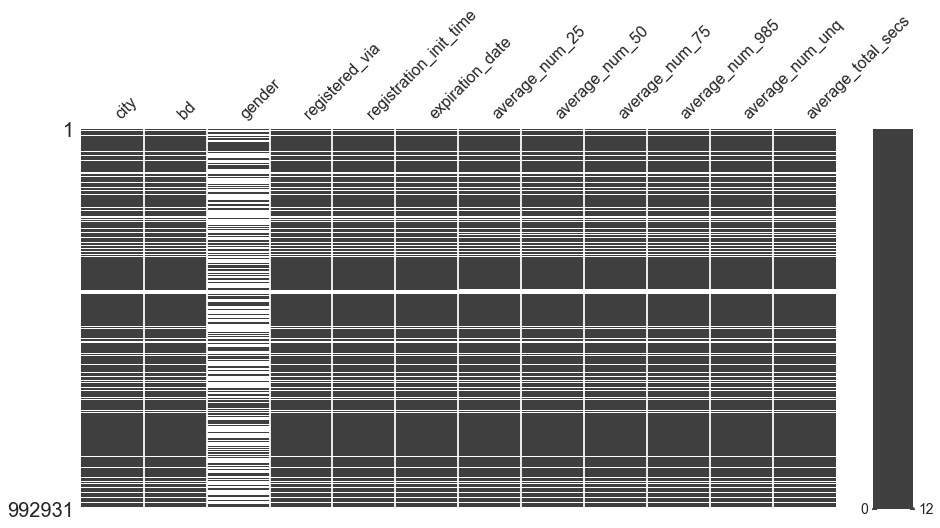

In [15]:
import missingno as msno

missing_columns = df_train.columns[df_train.isnull().any()].tolist()
msno.matrix(df_train[missing_columns], figsize=(15, 7))

In [16]:
df_test.shape

(970960, 21)

In [17]:
df_train.shape

(992931, 21)

In [18]:
df_train.drop(['gender'], axis=1, inplace=True)
df_test.drop(['gender'], axis=1, inplace=True)

In [19]:
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

### Feature Engineering

Time Interval Features

In [20]:
df_train['last_transaction_since_init'] = (df_train['transaction_date']-df_train['registration_init_time']).dt.days
df_test['last_transaction_since_init']  = (df_test['transaction_date']-df_test['registration_init_time']).dt.days

In [21]:
df_train['membership_duration'] = (df_train['membership_expire_date'] - df_train['transaction_date']).dt.days
df_test['membership_duration']  = (df_test['membership_expire_date'] - df_test['transaction_date']).dt.days

In [22]:
df_train['registration_duration'] = (df_train['expiration_date'] - df_train['registration_init_time']).dt.days
df_test['registration_duration']  = (df_test['expiration_date'] - df_test['registration_init_time']).dt.days

Quantitative Features

In [23]:
df_train['discount'] = (df_train['plan_list_price'] - df_train['actual_amount_paid'])
df_test['discount']  = (df_test['plan_list_price'] - df_test['actual_amount_paid'])

Possible other features:
    
- Logs count

In [24]:
df_train.drop(['transaction_date', 'membership_expire_date', 'expiration_date', 'registration_init_time'], axis=1, inplace=True)
df_test.drop(['transaction_date', 'membership_expire_date', 'expiration_date', 'registration_init_time'], axis=1, inplace=True)

In [25]:
df_train.head()

,is_churn,city,bd,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,average_num_25,average_num_50,average_num_75,average_num_985,average_num_unq,average_total_secs,last_transaction_since_init,membership_duration,registration_duration,discount
0,1,18.0,36.0,9.0,38,30,149,149,0,0,1.961538,0.615385,0.730769,0.423077,15.730769,17.769231,4294,30,4537,0
1,1,10.0,38.0,9.0,39,30,149,149,1,1,0.857965,0.301344,0.232246,0.341651,19.082534,13.880998,4341,25,4366,0
2,1,11.0,27.0,9.0,39,30,149,149,1,1,6.624473,4.008439,1.274262,2.021097,42.333333,48.662447,4106,22,4128,0
3,1,13.0,23.0,9.0,38,410,1788,1788,0,0,9.884354,3.292517,2.434014,2.223129,24.585034,25.141497,3717,411,4346,0
4,1,3.0,27.0,9.0,38,30,149,149,0,0,1.832454,0.941953,0.899736,4.258575,90.674142,95.875989,4049,30,4291,0


In [26]:
df_train.columns[df_train.isnull().any()].tolist()

[]

In [27]:
df_test.columns[df_test.isnull().any()].tolist()

[]

### Exploratory Analysis

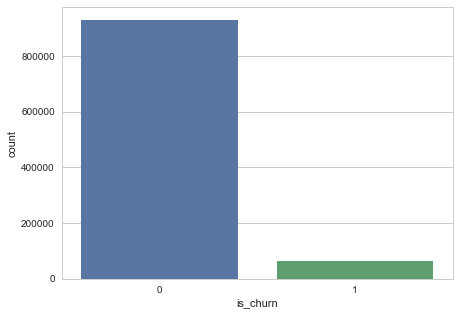

In [28]:
plt.figure(figsize=(7, 5))
sns.countplot(df_train['is_churn'])

Data is not balanced at all, as expected.

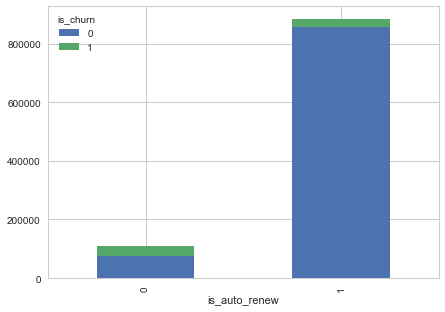

In [29]:
is_auto_renew_crosstab = pd.crosstab(df_train['is_auto_renew'], df_train['is_churn'])
is_auto_renew_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

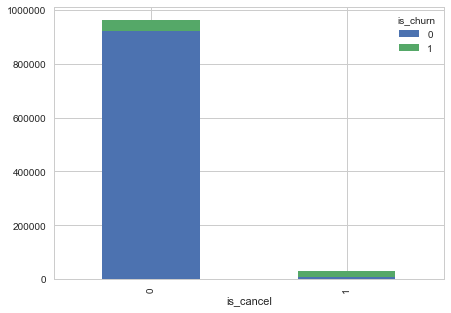

In [30]:
is_cancel_crosstab = pd.crosstab(df_train['is_cancel'], df_train['is_churn'])
is_cancel_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

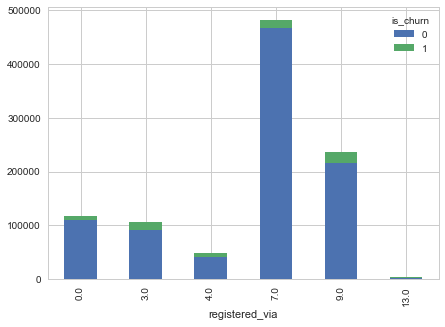

In [31]:
registered_via_crosstab = pd.crosstab(df_train['registered_via'], df_train['is_churn'])
registered_via_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

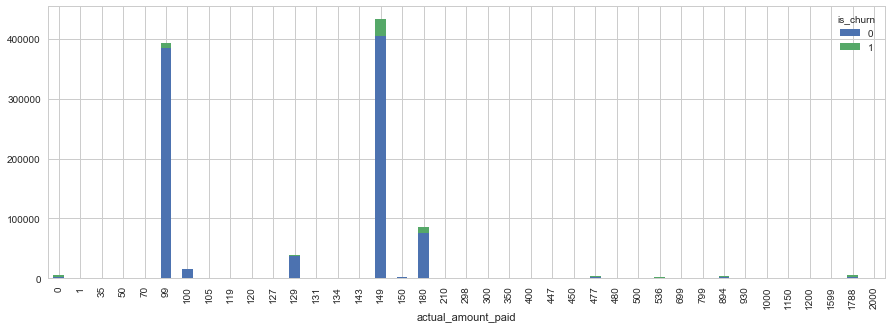

In [32]:
actual_amount_paid_crosstab = pd.crosstab(df_train['actual_amount_paid'], df_train['is_churn'])
actual_amount_paid_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

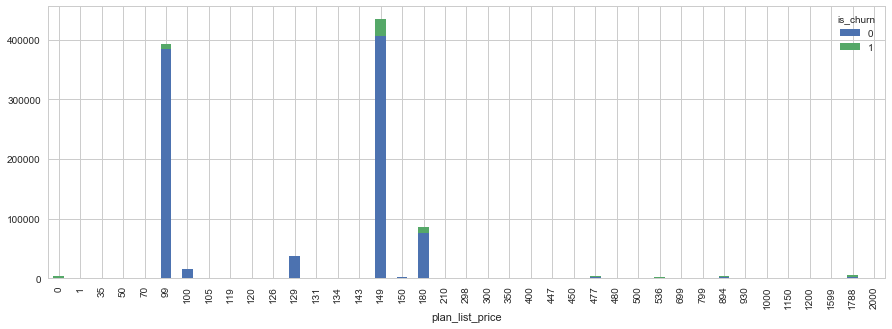

In [33]:
plan_list_price_crosstab = pd.crosstab(df_train['plan_list_price'], df_train['is_churn'])
plan_list_price_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

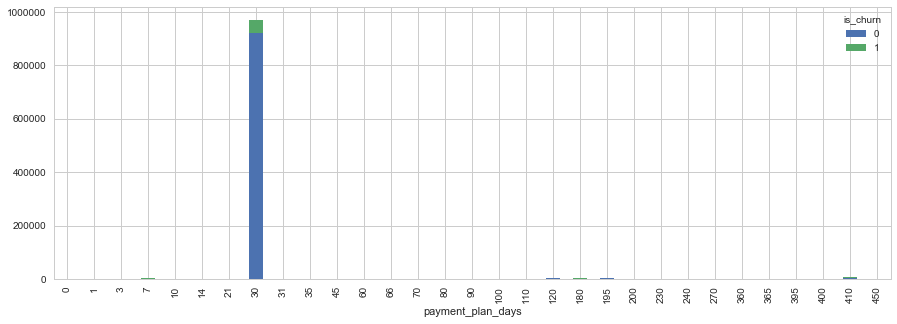

In [34]:
payment_plan_days_crosstab = pd.crosstab(df_train['payment_plan_days'], df_train['is_churn'])
payment_plan_days_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

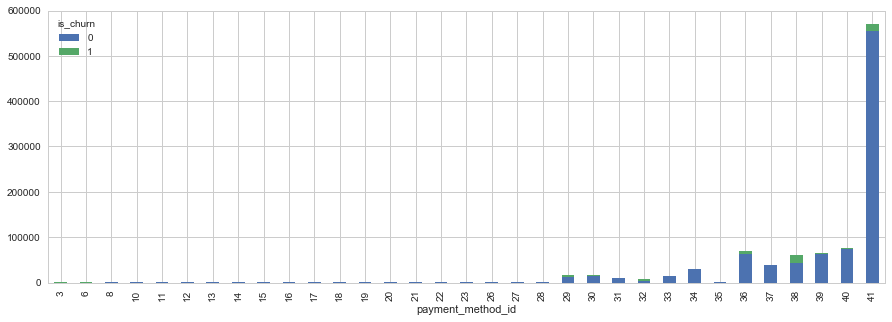

In [35]:
payment_method_id_crosstab = pd.crosstab(df_train['payment_method_id'], df_train['is_churn'])
payment_method_id_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

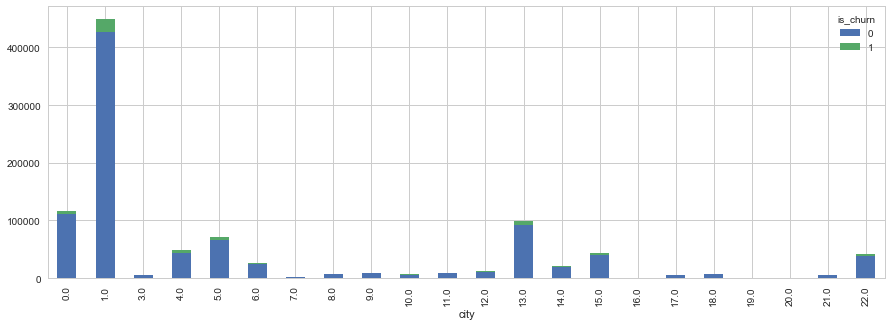

In [36]:
city_crosstab = pd.crosstab(df_train['city'], df_train['is_churn'])
city_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

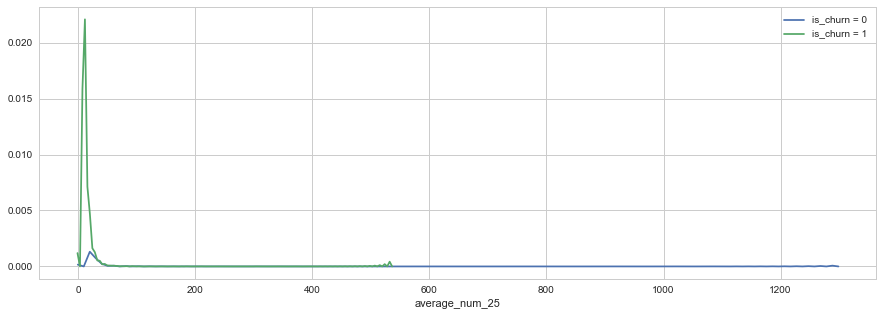

In [37]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train[df_train['is_churn'] == 0]['average_num_25'].fillna(0).astype(int), hist=False, label='is_churn = 0')
sns.distplot(df_train[df_train['is_churn'] == 1]['average_num_25'].fillna(0).astype(int), hist=False, label='is_churn = 1')

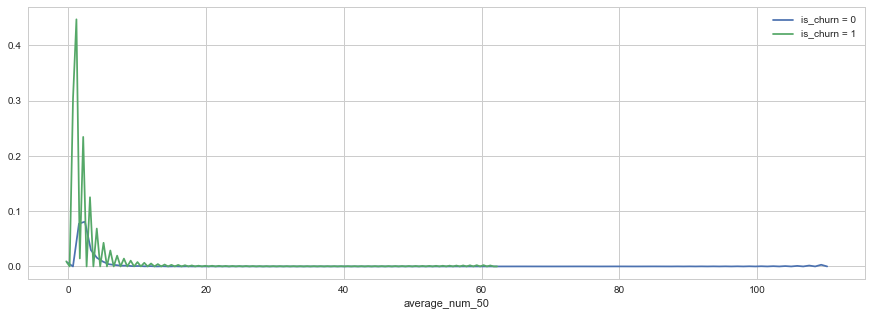

In [38]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train[df_train['is_churn'] == 0]['average_num_50'].fillna(0).astype(int), hist=False, label='is_churn = 0')
sns.distplot(df_train[df_train['is_churn'] == 1]['average_num_50'].fillna(0).astype(int), hist=False, label='is_churn = 1')

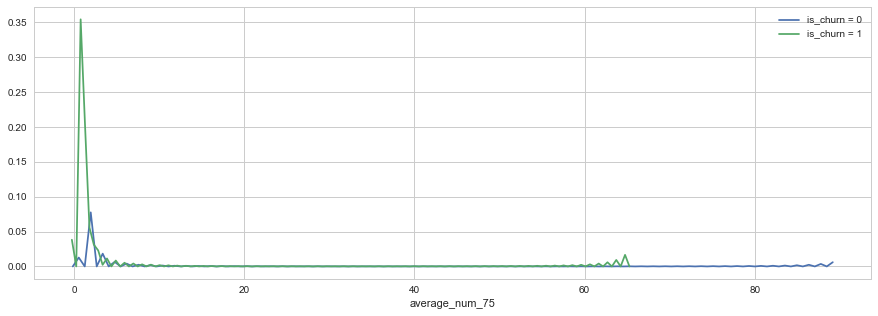

In [39]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train[df_train['is_churn'] == 0]['average_num_75'].fillna(0).astype(int), hist=False, label='is_churn = 0')
sns.distplot(df_train[df_train['is_churn'] == 1]['average_num_75'].fillna(0).astype(int), hist=False, label='is_churn = 1')

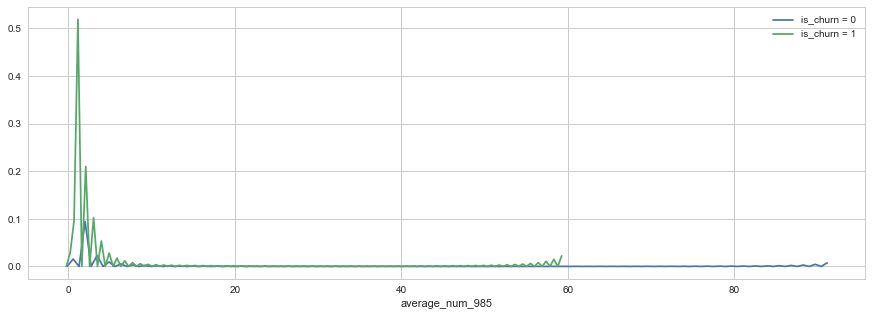

In [40]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train[df_train['is_churn'] == 0]['average_num_985'].fillna(0).astype(int), hist=False, label='is_churn = 0')
sns.distplot(df_train[df_train['is_churn'] == 1]['average_num_985'].fillna(0).astype(int), hist=False, label='is_churn = 1')

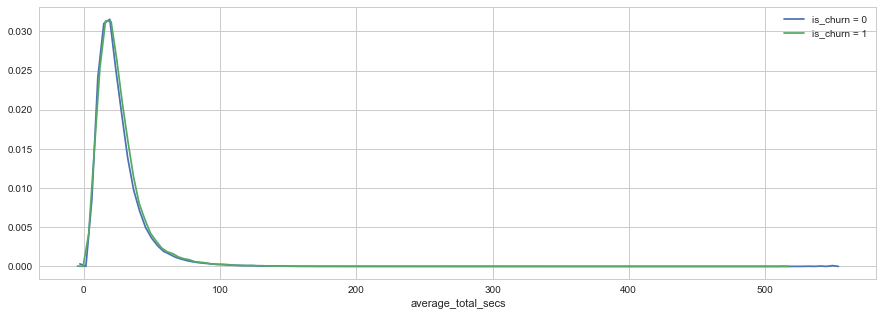

In [41]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train[df_train['is_churn'] == 0]['average_total_secs'].fillna(0).astype(int), hist=False, label='is_churn = 0')
sns.distplot(df_train[df_train['is_churn'] == 1]['average_total_secs'].fillna(0).astype(int), hist=False, label='is_churn = 1')

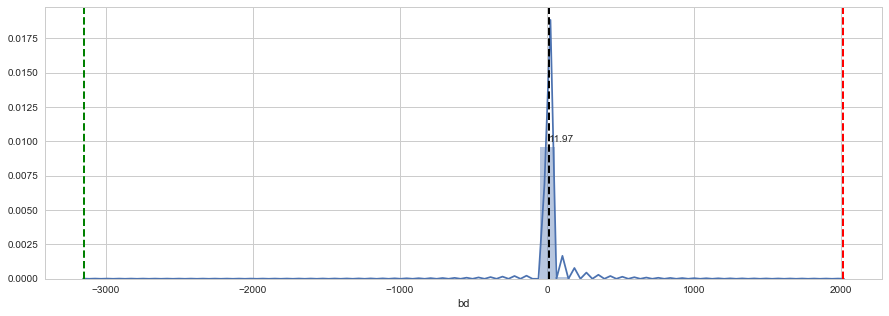

In [42]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train['bd'].fillna(0), rug=False)
plt.axvline(df_train['bd'].min(),  color='g', linestyle='dashed', linewidth=2)
plt.axvline(df_train['bd'].max(),  color='r', linestyle='dashed', linewidth=2)
h = df_train['bd'].mean()
plt.axvline(h, color='k', linestyle='dashed', linewidth=2)
plt.annotate('{0:.2f}'.format(h),xy=(h+0.5, 0.01))

In [28]:
for df in [df_train, df_test]:
    df[(df['bd'] < 0) | (df['bd'] > 100)] = 0

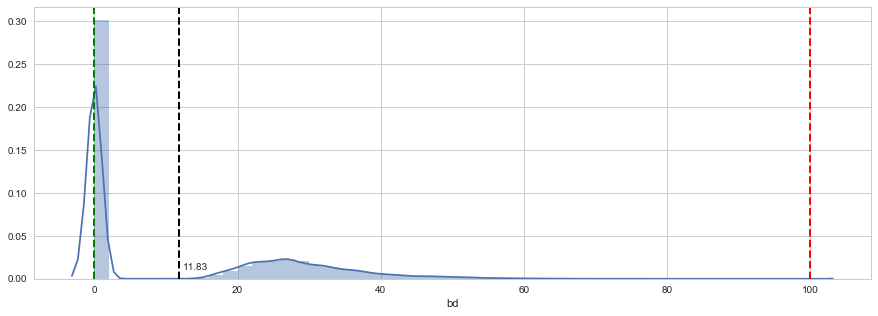

In [44]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train['bd'].fillna(0), rug=False)
plt.axvline(df_train['bd'].min(),  color='g', linestyle='dashed', linewidth=2)
plt.axvline(df_train['bd'].max(),  color='r', linestyle='dashed', linewidth=2)
h = df_train['bd'].mean()
plt.axvline(h, color='k', linestyle='dashed', linewidth=2)
plt.annotate('{0:.2f}'.format(h),xy=(h+0.5, 0.01))

### Data Preparation

In [29]:
categorical = ['city', 'bd', 'registered_via', 'payment_method_id', 
               'is_auto_renew', 'is_cancel']

In [30]:
df_train[categorical] = df_train[categorical].astype(int)

In [31]:
df_test[categorical] = df_test[categorical].astype(int)

Encoding categorical values.

In [32]:
from sklearn.preprocessing import LabelEncoder

In [33]:
le = LabelEncoder()

for df in [df_train, df_test]:
    for cat in categorical:
        df[cat] = le.fit_transform(df[cat])
        print(cat)
        print(le.classes_)
        print(le.transform(le.classes_))

city
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
bd
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
registered_via
[ 0  3  4  7  9 13]

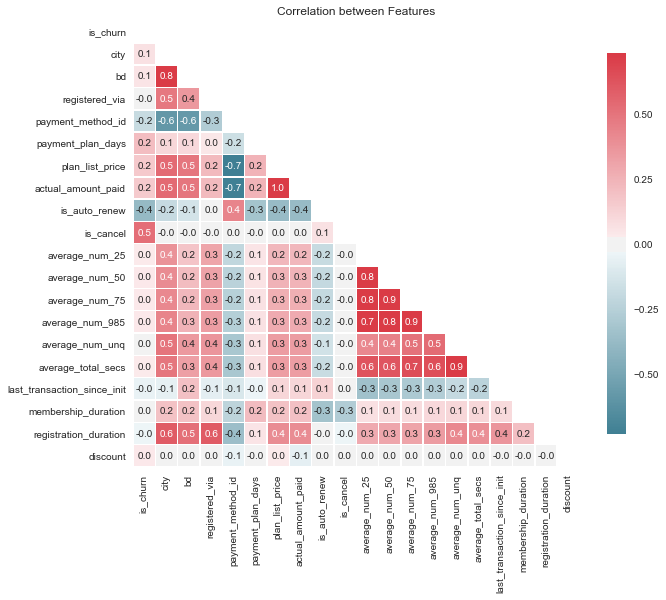

In [35]:
corr = df_train.corr('spearman')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, 
            cbar_kws={"shrink": .7}, annot=True, annot_kws={"size": 10}, fmt='.1f')
plt.title('Correlation between Features')

Getting dummies for categorical values.

In [34]:
train_objs_num = len(df_train)

dataset = pd.concat(objs=[df_train, df_test], axis=0)   
dataset = pd.get_dummies(columns=categorical, data=dataset)

df_train = dataset[:train_objs_num]
df_test  = dataset[train_objs_num:]

In [35]:
df_train.head()

,is_churn,payment_plan_days,plan_list_price,actual_amount_paid,average_num_25,average_num_50,average_num_75,average_num_985,average_num_unq,average_total_secs,last_transaction_since_init,membership_duration,registration_duration,discount,city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_20,city_21,bd_0,bd_1,bd_2,bd_3,bd_4,bd_5,bd_6,bd_7,bd_8,bd_9,bd_10,bd_11,bd_12,bd_13,bd_14,bd_15,bd_16,bd_17,bd_18,bd_19,bd_20,bd_21,bd_22,bd_23,bd_24,bd_25,bd_26,bd_27,bd_28,bd_29,bd_30,bd_31,bd_32,bd_33,bd_34,bd_35,bd_36,bd_37,bd_38,bd_39,bd_40,bd_41,bd_42,bd_43,bd_44,bd_45,bd_46,bd_47,bd_48,bd_49,bd_50,bd_51,bd_52,bd_53,bd_54,bd_55,bd_56,bd_57,bd_58,bd_59,bd_60,bd_61,bd_62,bd_63,bd_64,bd_65,bd_66,bd_67,bd_68,bd_69,bd_70,bd_71,bd_72,bd_73,bd_74,bd_75,bd_76,bd_77,bd_78,bd_79,bd_80,bd_81,bd_82,bd_83,bd_84,bd_85,bd_86,bd_87,bd_88,bd_89,bd_90,bd_91,bd_92,bd_93,bd_94,bd_95,bd_96,bd_97,bd_98,bd_99,bd_100,registered_via_0,registered_via_1,registered_via_2,registered_via_3,registered_via_4,registered_via_5,payment_method_id_0,payment_method_id_1,payment_method_id_2,payment_method_id_3,payment_method_id_4,payment_method_id_5,payment_method_id_6,payment_method_id_7,payment_method_id_8,payment_method_id_9,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_24,payment_method_id_25,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,is_auto_renew_0,is_auto_renew_1,is_cancel_0,is_cancel_1
0,1,30.0,149.0,149.0,1.961538,0.615385,0.730769,0.423077,15.730769,17.769231,4294,30,4537,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
1,1,30.0,149.0,149.0,0.857965,0.301344,0.232246,0.341651,19.082534,13.880998,4341,25,4366,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
2,1,30.0,149.0,149.0,6.624473,4.008439,1.274262,2.021097,42.333333,48.662447,4106,22,4128,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
3,1,410.0,1788.0,1788.0,9.884354,3.292517,2.434014,2.223129,24.585034,25.141497,3717,411,4346,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
4,1,30.0,149.0,149.0,1.832454,0.941953,0.899736,4.258575,90.674142,95.875989,4049,30,4291,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [37]:
X_train = df_train.drop(['is_churn'], axis=1)
y_train = df_train['is_churn']
X_valid  = df_test.drop(['is_churn'], axis=1)

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [39]:
del df_train
del df_test

In [40]:
gc.collect()

10277

### Modeling

In [41]:
from sklearn.externals import joblib

In [42]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = dict(enumerate(class_weight))

In [43]:
class_weight

{0: 0.53417365364492975, 1: 7.8155771577000275}

In [44]:
spw = class_weight[1]/class_weight[0]

In [45]:
def plot_importances(clf, features, top=None):
    importances = clf.feature_importances_[:top]
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(15, 5))
    plt.title("Feature importance")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), features[indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.show()

In [46]:
idx = np.random.choice(np.arange(len(y_train)), round(len(y_train)*0.10), replace=False)
X_sample = X_train.iloc[idx]
y_sample = y_train.iloc[idx]

In [49]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#### Light GBM

In [47]:
import lightgbm as lgb

[**Parameter Tunning**](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

To get good results using a leaf-wise tree, these are some important parameters:

- `num_leaves`: This is the main parameter to control the complexity of the tree model.
- `min_data_in_leaf`: This is a very important parameter to deal with over-fitting in leaf-wise tree. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
- `max_depth`: You also can use max_depth to limit the tree depth explicitly.

Deal with Over-fitting

- Use small `max_bin`
- Use small `num_leaves`
- Use `min_data_in_leaf` and `min_sum_hessian_in_leaf`
- Use `bagging` by set `bagging_fraction` and `bagging_freq`
- Use feature sub-sampling by set `feature_fraction`
- Try `lambda_l1`, `lambda_l2` and `min_gain_to_spli`t for regularization
 Try `max_depth` to avoid growing deep tree

In [52]:
clf_lgbm = lgb.LGBMClassifier(random_state=0, is_unbalance=True)
model_params = {
    'num_leaves':           [30, 70, 110, 150],
    'min_data_in_leaf':     [20, 40, 60],
    'max_depth':            [-1, 3, 7, 10],
    'bagging_fraction':     [0.6, 0.8, 1.0],
    'bagging_freq':         [0, 5, 10],
    'learning_rate':        [0.01, 0.05, 0.1, 0.5],
    'feature_fraction':     [0.2, 0.4, 0.6, 0.8, 1.0],
    'max_bin':              [50, 150, 250]
}

grid = RandomizedSearchCV(clf_lgbm, model_params, cv=3, verbose=1, scoring='log_loss', n_iter=1000, n_jobs=-1)
grid.fit(X_sample, y_sample)

print (grid.best_params_)
print (grid.best_score_)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 15.1min finished


{'num_leaves': 150, 'min_data_in_leaf': 20, 'max_depth': -1, 'max_bin': 150, 'learning_rate': 0.5, 'feature_fraction': 1.0, 'bagging_freq': 5, 'bagging_fraction': 1.0}
0.940567011607


In [53]:
clf_lgbm = grid.best_estimator_

In [54]:
scores = cross_val_score(clf_lgbm, X_test, y_test, cv=3, n_jobs=-1, scoring='log_loss')
print("Log Loss: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Log Loss: -0.16 (+/- 0.01)


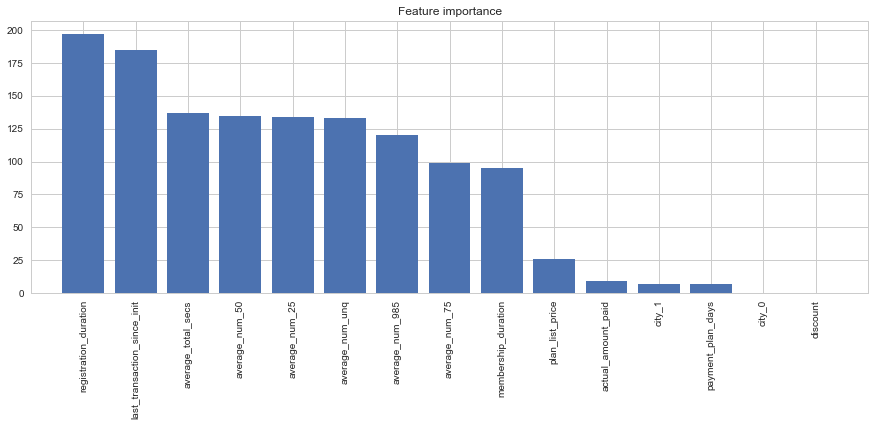

In [56]:
plot_importances(clf_lgbm, X_sample.columns, 15)

In [57]:
y_pred = clf_lgbm.predict_proba(X_valid)

In [58]:
submission = pd.DataFrame.from_items([('msno', df_ids), ('is_churn', y_pred[:, 1])])
submission.to_csv('clf_lgbm_output.csv', index=False)

In [59]:
joblib.dump(clf_lgbm, '../clf_lgbm_Churn.pkl') 

['../clf_lgbm_Churn.pkl']